In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import firedrake
import icepack, icepack.models, icepack.plot
from icepack.constants import ice_density as ρ_I, water_density as ρ_W

In [2]:
Lx, Ly = 50e3, 12e3
nx, ny = 48, 32
mesh2d = firedrake.RectangleMesh(nx, ny, Lx, Ly)
mesh = firedrake.ExtrudedMesh(mesh2d, layers=1)

In [3]:
Q = firedrake.FunctionSpace(mesh, family='CG', degree=2, vfamily='DG', vdegree=0)
V = firedrake.VectorFunctionSpace(mesh, dim=2, family='CG', degree=2, vfamily='GL', vdegree=5)

In [4]:
Q3D = firedrake.FunctionSpace(mesh, family='DG', degree=2, vfamily='GL', vdegree=1+V.ufl_element().degree()[1])

In [5]:
from icepack.constants import (ice_density as ρ_I, water_density as ρ_W,
                               gravity as g)

x, y, ζ = firedrake.SpatialCoordinate(mesh)

In [6]:
b_in, b_out = 200, -400
b = firedrake.interpolate(b_in - (b_in - b_out) * x / Lx, Q)

s_in, s_out = 850, 50
s0 = firedrake.interpolate(s_in - (s_in - s_out) * x / Lx, Q)

h0 = firedrake.interpolate(s0 - b, Q)

In [7]:
h_in = s_in - b_in
δs_δx = (s_out - s_in) / Lx
τ_D = -ρ_I * g * h_in * δs_δx

In [8]:
u_in, u_out = 0.0, 2400
velocity_x = u_in + (u_out - u_in) * (x/Lx)**2
u0 = firedrake.interpolate(firedrake.as_vector((velocity_x, 0)), V)

In [9]:
age=firedrake.interpolate(firedrake.Constant(0.0),Q3D)

In [10]:
temp = 255.0
A = firedrake.Constant(icepack.rate_factor(temp))

In [11]:
from icepack.constants import weertman_sliding_law as m
C = firedrake.interpolate((0.95 - 0.40 * firedrake.sin(10*firedrake.pi*x/Lx)) * τ_D / 20.0**(1/m),Q)

p_W = ρ_W * g * firedrake.max_value(0, h0 - s0)
p_I = ρ_I * g * h0
ϕ = 1 - p_W / p_I

In [12]:
beta = firedrake.interpolate(C,Q)

In [13]:
import icepack.models.hybrid
def friction(**kwargs):
    u = kwargs['velocity']
    h = kwargs['thickness']
    s = kwargs['surface']
    C = kwargs['friction']
    
    p_W = ρ_W * g * firedrake.max_value(0, h - s)
    p_I = ρ_I * g * h
    ϕ = 1 - p_W / p_I
    return icepack.models.hybrid.bed_friction(
        velocity=u, 
        friction=C * ϕ
    )

In [15]:
model = icepack.models.HybridModel(friction=friction)
opts = {'dirichlet_ids': [1], 'side_wall_ids': [3, 4]}
solver = icepack.solvers.FlowSolver(model, **opts)

u0 = solver.diagnostic_solve(
    velocity=u0,
    thickness=h0,
    surface=s0,
    fluidity=A,
    friction=C
)


In [16]:
age_model = icepack.models.AgeTransport()
age_solver = icepack.solvers.AgeSolver(age_model)

In [17]:
import tqdm
import os
num_years = 2000
timesteps_per_year = .2

δt = 1.0 / timesteps_per_year
num_timesteps = int(num_years * timesteps_per_year)

a = firedrake.interpolate(firedrake.Constant(1.0), Q)
h = h0.copy(deepcopy=True)
u = u0.copy(deepcopy=True)
s = icepack.compute_surface(thickness=h, bed=b)

if not os.path.exists('degree-5.h5'):
    for step in tqdm.trange(num_timesteps):
        h = solver.prognostic_solve(
            δt,
            thickness=h,
            velocity=u,
            accumulation=a,
            thickness_inflow=h0
        )
        s = icepack.compute_surface(thickness=h, bed=b)
    
        u = solver.diagnostic_solve(
            velocity=u,
            thickness=h,
            surface=s,
            fluidity=A,
            friction=C
        )
    
    with firedrake.DumbCheckpoint(
        'degree-5', mode=firedrake.FILE_CREATE
    ) as checkpoint:
        checkpoint.store(h, name='thickness')
        checkpoint.store(s, name='surface')
        checkpoint.store(u, name='velocity')

else:    
    with firedrake.DumbCheckpoint(
        'degree-5', mode=firedrake.FILE_READ
    ) as checkpoint:
        checkpoint.load(h, name='thickness')
        checkpoint.load(s, name='surface')
        checkpoint.load(u, name='velocity')

100%|██████████| 400/400 [45:49<00:00,  6.87s/it] 


In [18]:
w=firedrake.interpolate(icepack.utilities.vertical_velocity(u,h),Q3D)

In [19]:
V3D = firedrake.VectorFunctionSpace(mesh,dim=3, family='CG',degree=2,vfamily='GL',vdegree=1+V.ufl_element().degree()[1])
u3D = firedrake.Function(V3D).interpolate(firedrake.as_vector((u[0],u[1],w)))

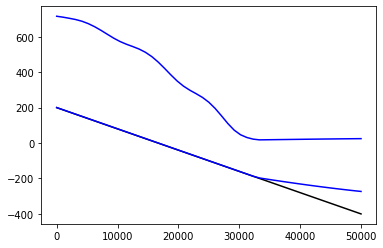

In [36]:
import numpy as np
xs = np.array([(Lx * k / nx, 0, .5) for k in range(nx + 1)])
ss = np.array(s.at(xs, tolerance=1e-10))
hs = np.array(h.at(xs, tolerance=1e-10))
bs = np.array(b.at(xs, tolerance=1e-10))

fig, axes = plt.subplots()
axes.plot(xs[:, 0], bs, color='black')
axes.plot(xs[:, 0], ss - hs, color='blue')
axes.plot(xs[:, 0], ss, color='blue')
plt.show(fig)

In [37]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

nz=20

xz = np.array([(Lx * k / nx, 0, i)  for k in range(nx + 1) for i in np.arange(0.0,1.0,1.0/nz)])
wM= np.array(w.at(xz, tolerance=1e-10))
wM=np.reshape(wM,(49,nz));
xz=np.reshape(xz,(49,nz,3));
hz=np.reshape(np.repeat(hs,nz),(49,nz));
hz=np.multiply(xz[:,:,2],hz);



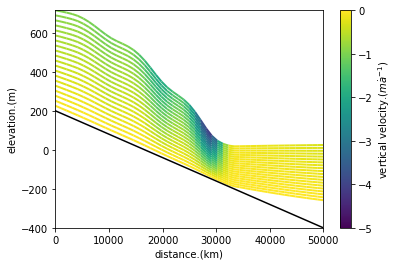

In [38]:
fig, axs = plt.subplots()
for i in range(0,nz):
    points = np.array([np.squeeze(xz[:,i,0]),np.squeeze(ss-hz[:,i])]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    norm = plt.Normalize(-5, 0)
    lc = LineCollection(segments, cmap='viridis', norm=norm)
    # Set the values used for colormapping
    lc.set_array(np.squeeze(wM[:,nz-1-i]))
    lc.set_linewidth(2)
    line = axs.add_collection(lc)
axs.set_xlim(xz.min(), xz.max())
axs.set_ylim(bs.min(), ss.max())
axs.plot(xs[:, 0], bs, color='black')
fig.colorbar(line, ax=axs,label=r'vertical velocity.$(m\dota^{-1})$')
axs.set_ylabel('elevation.(m)')
axs.set_xlabel('distance.(km)')
plt.show()

In [33]:
import tqdm

num_years = 500000.0
timesteps_per_year = 0.1

δt = 1.0 / timesteps_per_year
num_timesteps = int(num_years * timesteps_per_year)

for step in tqdm.trange(num_timesteps):
    age = age_solver.solve(δt,velocity=u,thickness=h,age=age)
    

100%|██████████| 50000/50000 [14:32:07<00:00,  1.05s/it]  


In [34]:
xz = np.array([(Lx * k / nx, 0, i)  for k in range(nx + 1) for i in np.arange(0,1.0,1.0/nz)])
ageM= np.array(age.at(xz, tolerance=1e-10))
ageM=np.reshape(ageM,(49,nz));
xz=np.reshape(xz,(49,nz,3));

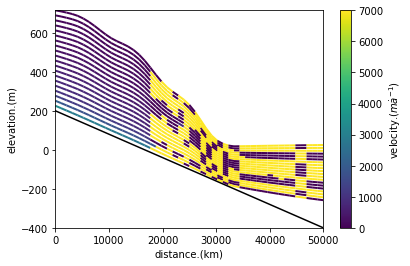

In [35]:
fig, axs = plt.subplots()
for i in range(0,nz):
    points = np.array([np.squeeze(xz[:,i,0]),np.squeeze(ss-hz[:,i])]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    norm = plt.Normalize(0,7000)
    lc = LineCollection(segments, cmap='viridis', norm=norm)
    # Set the values used for colormapping
    lc.set_array(np.squeeze(ageM[:,nz-1-i]))
    lc.set_linewidth(2)
    line = axs.add_collection(lc)
axs.set_xlim(xz.min(), xz.max())
axs.set_ylim(bs.min(), ss.max())
axs.plot(xs[:, 0], bs, color='black')
fig.colorbar(line, ax=axs,label=r'velocity.$(m\dota^{-1})$')
axs.set_ylabel('elevation.(m)')
axs.set_xlabel('distance.(km)')
plt.show()

In [31]:
import numpy as np
np.min(age.dat.data)

-6052891.767930022

In [32]:
age.dat.data

array([ 2.61333974e+03,  1.17069687e+03,  7.34421997e+02, ...,
        2.28430834e+06,  8.62113463e+04, -3.96973319e+05])

In [28]:
age_model = icepack.models.AgeTransport()
age_solver = icepack.solvers.AgeSolver(age_model)

# Method of characteristics
We use the method of characteristics to solve the age equation, which can be written as

$$\vec{u}\cdot\nabla \mathcal{A} + \frac{\partial\mathcal{A}}{\partial t} = 1$$.

We want to transform this linear first-order PDE into an ODE along the appropriate curve; i.e. something of the form

$$\frac{d}{ds} \mathcal{A}(x(s),t(s) = F(\mathcal{A},x(s),t(s))$$

where (x(s),t(s)) is the characteristic volume. Using the chain rule, we can rewrite this description of the age evolution as

$$\frac{d}{ds} \mathcal{A}(x(s),t(s) = \frac{\partial \mathcal{A}}{\partial x} \frac{d x}{d s} +\frac{\partial \mathcal{A}}{\partial y} \frac{d y}{d s} +\frac{\partial \mathcal{A}}{\partial z} \frac{d z}{d s} + \frac{\partial \mathcal{A}}{\partial t} \frac{dt}{ds}.$$

If we set $\frac{d t}{d s} = 1$ and $\frac{d \vec{x}}{d s} = \vec{u}$, we see that 

$$\frac{d}{ds} \mathcal{A}(x(s),t(s) = \vec{u}\cdot\nabla \mathcal{A}+ \frac{\partial\mathcal{A}}{\partial t}, $$ 

which is just the left hand side of the PDE we started with. Thus, 

$$\frac{d \mathcal{A}}{ds} = 1$$

$$\frac{d t}{ds} = 1$$

$$\frac{d x}{ds} = \vec{u}$$

and the original PDE becomes a system of ordinary differential equations that we can solve with respect to s.
